### Домашнее задание
1. Обучить любую модель классификации на датасете IRIS до применения самописного PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.
2. *Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statistics import mode
from sklearn.decomposition import PCA

%matplotlib inline

### Задание1
Обучить любую модель классификации на датасете IRIS до применения самописного PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.

In [2]:
X, y = load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

In [3]:
X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [4]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_tr)
X_test = scaler.transform(X_ts)

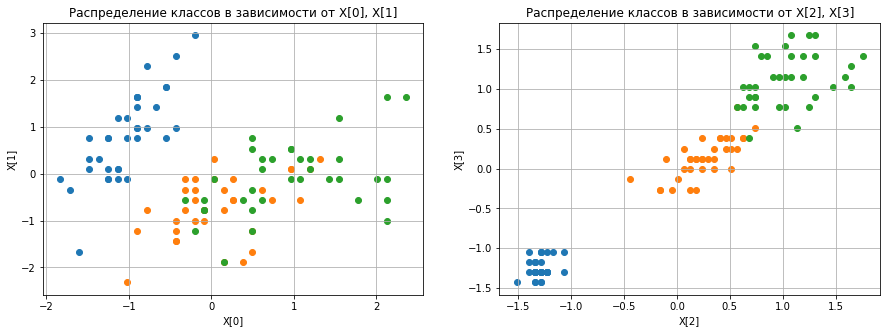

In [5]:
plt.figure(figsize=(15, 5))
y = y_train
plt.subplot(1,2,1)
plt.grid()
plt.title('Распределение клаcсов в зависимости от X[0], X[1]')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X_train[y == i, 0], X_train[y == i, 1])

plt.subplot(1,2,2)
plt.title('Распределение клаcсов в зависимости от X[2], X[3]')
plt.xlabel('X[2]')
plt.ylabel('X[3]')
plt.grid()
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X_train[y == i, 2], X_train[y == i, 3])

In [6]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [7]:
def knn(X_train, y_train, X_test, k):
    mx_test = np.repeat(X_test, X_train.shape[0], axis=0).reshape(-1, X_train.shape[0], X_train.shape[1])
    mx_train = np.repeat(X_train, X_test.shape[0], axis=0).reshape(-1, X_test.shape[0], X_train.shape[1])
    mx_train_T = np.transpose(mx_train, (1,0,2))
    mx_dist = np.array(np.linalg.norm(mx_test-mx_train_T, ord=2, axis=2))
    index_min = np.argsort(mx_dist)
    classes = y_train[index_min[:,:k]]
    result = np.apply_along_axis(mode, axis=1, arr=classes)
    return result

In [8]:
y_pred = knn(X_train, y_train, X_test, k=4)

In [9]:
print(f'Точность алгоритма knn обученного на всех признаках датасета: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма knn обученного на всех признаках датасета: 0.933


In [10]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((105, 2), (45, 2))

In [11]:
y_pred_pca = knn(X_train_pca, y_train, X_test_pca, k=4)

In [12]:
print(f'Точность алгоритма knn обученного на датасете после PCA: {accuracy(y_pred_pca, y_test):.3f}')

Точность алгоритма knn обученного на датасете после PCA: 0.911


Проанализировав график "Распределение клаcсов в зависимости от X[2], X[3]" исключим из обучения признаки 0 и 1. И обучим модель на двух оставшихся признаках.

In [13]:
X_train_sel = X_train[:, [2,3]]

In [14]:
X_test_sel = X_test[:,[2,3]]

In [15]:
y_pred_sel = knn(X_train_sel, y_train, X_test_sel, k=4)

In [16]:
print(f'Точность алгоритма knn обученного на двух признаках [2,3] начального датасета: {accuracy(y_pred_sel, y_test):.3f}')

Точность алгоритма knn обученного на двух признаках [2,3] начального датасета: 0.956


#### Выводы: 
1. Классический вариант модели knn обученный на всём датасэте показал метрику 0,933. После понижения размерности до 2 признаков методом РСА тот же алгоритм показал метрику 0,911 что соответствует теоретическим прогнозам. Это объясняется тем, что при понижении размерности происходит некоторая потеря информации. 
2. Показательно, что простой отбор признаков сработал лучше. В данном примере я исключил из обучения модели признаки 0 и 1 и получил метрику 0,956. Это показывает нам, что при анализе данных нельзя пренебрегать одними алгоритмом в пользу другого, и что даже самый простой алгоритм может сработать лучше самого сложного.  

### Задание2
*Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [17]:
class PCA_SVD:
    
    def __init__(self, n_components):
        self.n_components = n_components
        self.W = None
        
        
    def fit_tranform(self, X_train):
        U, d, V = np.linalg.svd(X_train)
        self.W = V.T[:, :self.n_components]
        return np.dot(X_train, self.W)
        
        
    def transform(self, X_test):
        return np.dot(X_test, self.W)
    

In [18]:
pca_my = PCA_SVD(n_components=2)
X_train_svd = pca_my.fit_tranform(X_train)
X_test_svd = pca_my.transform(X_test)

In [19]:
X_train_svd.shape, X_test_svd.shape

((105, 2), (45, 2))

In [20]:
y_pred_svd = knn(X_train_svd, y_train, X_test_svd, k=4)

In [21]:
print(f'Точность алгоритма knn обученного на датасете после понижения размерности на основые SVD: '
      f'{accuracy(y_pred_svd, y_test):.3f}')

Точность алгоритма knn обученного на датасете после понижения размерности на основые SVD: 0.911


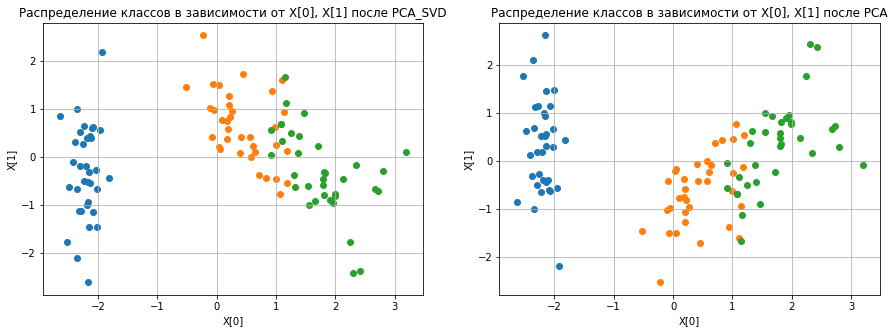

In [22]:
plt.figure(figsize=(15, 5))
y = y_train
plt.subplot(1,2,1)
plt.grid()
plt.title('Распределение клаcсов в зависимости от X[0], X[1] после РСА_SVD')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X_train_svd[y_train == i, 0], X_train_svd[y_train == i, 1])
    
    
plt.subplot(1,2,2)
plt.grid()
plt.title('Распределение клаcсов в зависимости от X[0], X[1] после РСА')
plt.xlabel('X[0]')
plt.ylabel('X[1]')
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X_train_pca[y_train == i, 0], X_train_pca[y_train == i, 1])

PCA_SVD зеркальная копия РСА.